In [107]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import xgboost

%matplotlib inline

from numpy import asarray
import numpy as np
from pandas import concat
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from matplotlib import pyplot

import requests, json

In [108]:
# Get the USGS water data as JSON
usgs_water_api = "http://waterservices.usgs.gov/nwis/iv?sites=01388500&period=P7D&format=json"
api_response = requests.get(usgs_water_api)
water_data = api_response.json()

# Extract interesting data from the JSON
site_name = water_data["value"]["timeSeries"][0]["sourceInfo"]["siteName"]
station_id = water_data["value"]["timeSeries"][0]["sourceInfo"]["siteCode"][0]["value"]
agency_code = water_data["value"]["timeSeries"][0]["sourceInfo"]["siteCode"][0]["agencyCode"]

date_time_last = water_data["value"]["timeSeries"][1]["values"][0]["value"][-3]["dateTime"]
date_time_mid = water_data["value"]["timeSeries"][1]["values"][0]["value"][-2]["dateTime"]
date_time_current = water_data["value"]["timeSeries"][1]["values"][0]["value"][-1]["dateTime"]

streamflow_last = water_data["value"]["timeSeries"][0]["values"][0]["value"][-3]["value"]
streamflow_mid = water_data["value"]["timeSeries"][0]["values"][0]["value"][-2]["value"]
streamflow_current = water_data["value"]["timeSeries"][0]["values"][0]["value"][-1]["value"]

gage_height_last = water_data["value"]["timeSeries"][1]["values"][0]["value"][-3]["value"]
gage_height_mid = water_data["value"]["timeSeries"][1]["values"][0]["value"][-2]["value"]
gage_height_current = water_data["value"]["timeSeries"][1]["values"][0]["value"][-1]["value"]



# Print the data
print(f"Site name: {site_name}")

print(f"Current Datetime: {date_time_current}")
print(f"Last Datetime: {date_time_last}")

print(f"Station ID: {station_id}")
print(f"Agency code: {agency_code}")

print(f"Current Streamflow (ft3/s): {streamflow_last}")
print(f"Last Streamflow (ft3/s): {streamflow_current}")

print(f"Current Gage height (ft): {gage_height_last}")
print(f"Last Gage height (ft): {gage_height_current}")


Site name: Pompton River at Pompton Plains NJ
Current Datetime: 2024-10-21T11:45:00.000-04:00
Last Datetime: 2024-10-21T11:15:00.000-04:00
Station ID: 01388500
Agency code: USGS
Current Streamflow (ft3/s): 89.4
Last Streamflow (ft3/s): 89.4
Current Gage height (ft): 7.86
Last Gage height (ft): 7.86


In [109]:
water_data

{'name': 'ns1:timeSeriesResponseType',
 'declaredType': 'org.cuahsi.waterml.TimeSeriesResponseType',
 'scope': 'javax.xml.bind.JAXBElement$GlobalScope',
 'value': {'queryInfo': {'queryURL': 'http://waterservices.usgs.gov/nwis/ivsites=01388500&period=P7D&format=json',
   'criteria': {'locationParam': '[ALL:01388500]',
    'variableParam': 'ALL',
    'parameter': []},
   'note': [{'value': '[ALL:01388500]', 'title': 'filter:sites'},
    {'value': '[mode=PERIOD, period=P7D, modifiedSince=null]',
     'title': 'filter:timeRange'},
    {'value': 'methodIds=[ALL]', 'title': 'filter:methodId'},
    {'value': '2024-10-21T16:17:16.755Z', 'title': 'requestDT'},
    {'value': 'f0799b20-8fc7-11ef-842d-2cea7f5e5ede', 'title': 'requestId'},
    {'value': 'Provisional data are subject to revision. Go to http://waterdata.usgs.gov/nwis/help/?provisional for more information.',
     'title': 'disclaimer'},
    {'value': 'sdas01', 'title': 'server'}]},
  'timeSeries': [{'sourceInfo': {'siteName': 'Pompto

In [110]:
df = pd.DataFrame(water_data)
#df = df.set_index('datetime')

In [111]:
df

,name,declaredType,scope,value,nil,globalScope,typeSubstituted
queryInfo,ns1:timeSeriesResponseType,org.cuahsi.waterml.TimeSeriesResponseType,javax.xml.bind.JAXBElement$GlobalScope,{'queryURL': 'http://waterservices.usgs.gov/nw...,False,True,False
timeSeries,ns1:timeSeriesResponseType,org.cuahsi.waterml.TimeSeriesResponseType,javax.xml.bind.JAXBElement$GlobalScope,[{'sourceInfo': {'siteName': 'Pompton River at...,False,True,False


In [112]:
# Enter the begin and end dates for the gage and flow data
begin_date = '2022-01-01T00:00:00.000-05:00'
end_date = '2024-10-21T12:00:00.000-05:00'

In [113]:
#Read in raw stream gage data
gage = pd.read_csv('https://nwis.waterservices.usgs.gov/nwis/iv/?sites=01388500&parameterCd=00065&startDT='+begin_date+'&endDT='+end_date+'&siteStatus=all&format=rdb', sep='\t', skiprows=27)
gage = gage.iloc[1: , :]
gage['194446_00065'] = gage['194446_00065'].astype(float)
gage = gage[['datetime','194446_00065']]
gage = gage.set_index('datetime')
gage.head()

,194446_00065
datetime,
2022-01-01 01:00,8.3
2022-01-01 01:15,8.3
2022-01-01 01:30,8.3
2022-01-01 01:45,8.3
2022-01-01 02:00,8.3


In [114]:
#Read in raw flow data
flow = pd.read_csv('https://waterservices.usgs.gov/nwis/iv/?sites=01388500&parameterCd=00060&startDT='+begin_date+'&endDT='+end_date+'&siteStatus=all&format=rdb', sep='\t', skiprows=27)
flow = flow.iloc[1: , :]
flow['194445_00060'] = flow['194445_00060'].astype(float)
flow = flow[['datetime','194445_00060']]
flow = flow.set_index('datetime')
flow.head()

,194445_00060
datetime,
2022-01-01 01:00,248.0
2022-01-01 01:15,248.0
2022-01-01 01:30,248.0
2022-01-01 01:45,248.0
2022-01-01 02:00,248.0


In [115]:
# Merge datasets together on datetime index and check if everything is good
df=pd.merge(gage, flow, how='inner', left_index=True, right_index=True)
df.head()

,194446_00065,194445_00060
datetime,,
2022-01-01 01:00,8.3,248.0
2022-01-01 01:15,8.3,248.0
2022-01-01 01:30,8.3,248.0
2022-01-01 01:45,8.3,248.0
2022-01-01 02:00,8.3,248.0


In [116]:
# Rename gage and flow rate colums to something humane and check the dataframe
df = df.rename(columns={"194446_00065": "Gage", "194445_00060": "Flow"  })
df.head()

,Gage,Flow
datetime,,
2022-01-01 01:00,8.3,248.0
2022-01-01 01:15,8.3,248.0
2022-01-01 01:30,8.3,248.0
2022-01-01 01:45,8.3,248.0
2022-01-01 02:00,8.3,248.0


# Check the Gage time series
plt.figure(figsize=(10,6))
plt.plot(df['Gage'])
plt.xlabel('Datetime')
plt.ylabel('Gage (ft)')
 
# displaying the title
plt.title("Gage Readings")
plt.show()
plt.show()

# Check the Flow time series
plt.figure(figsize=(10,6))
plt.plot(df['Flow'])
plt.xlabel('Datetime')
plt.ylabel('Flow (cfs)')
 
# displaying the title
plt.title("Flow Readings")
plt.show()
plt.show()

In [117]:
#check the number of training rows
print('number of rows = ', df.shape[0])

number of rows =  98355


In [118]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    
    #put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [119]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()

    # split dataset
    train, test = train_test_split(data, n_test)

    # seed history with training dataset
    history = [x for x in train]

    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

    # estimate prediction error
    #error = mean_absolute_error(test[:, -1], predictions)
    error = mean_squared_error(test[:, -1], predictions)
    return error, test[:, 1], predictions

In [120]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [121]:
def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]

    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)

    # make a one-step prediction
    
    yhat = model.predict([testX])
    return yhat[0]

In [122]:
df.head()

,Gage,Flow
datetime,,
2022-01-01 01:00,8.3,248.0
2022-01-01 01:15,8.3,248.0
2022-01-01 01:30,8.3,248.0
2022-01-01 01:45,8.3,248.0
2022-01-01 02:00,8.3,248.0


In [123]:
df = df.drop(['Flow'], axis=1)

In [130]:
df

,Gage
datetime,
2022-01-01 01:00,8.30
2022-01-01 01:15,8.30
2022-01-01 01:30,8.30
2022-01-01 01:45,8.30
2022-01-01 02:00,8.30
...,...
2024-10-21 10:45,7.86
2024-10-21 11:00,7.86
2024-10-21 11:15,7.86


In [124]:
# transform the time series data into supervised learning
data = series_to_supervised(df, n_in=1)

In [125]:
print (data)

[[8.3  8.3 ]
 [8.3  8.3 ]
 [8.3  8.3 ]
 ...
 [7.86 7.86]
 [7.86 7.86]
 [7.86 7.86]]


In [126]:
# evaluate
mse, y, yhat = walk_forward_validation(data, 3)

>expected=7.9, predicted=7.9
>expected=7.9, predicted=7.9
>expected=7.9, predicted=7.9
>expected=7.9, predicted=7.9
>expected=7.9, predicted=7.9
>expected=7.9, predicted=7.9
>expected=7.9, predicted=7.9
>expected=7.9, predicted=7.9
>expected=7.9, predicted=7.9
>expected=7.9, predicted=7.9
>expected=7.9, predicted=7.9
>expected=7.9, predicted=7.9


In [127]:
mse

1.302225315756837e-08

In [128]:
# RMSE Computation 
rmse = np.sqrt(mse) 
print("RMSE : % f" %(rmse)) 

RMSE :  0.000114


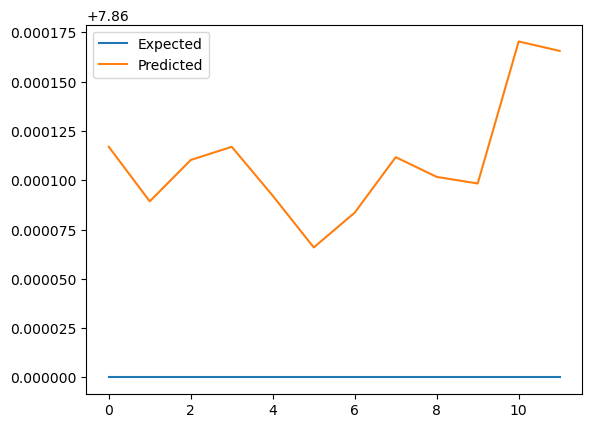

In [129]:
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()